In [1]:
!pip install autogen[graph] -q

## Wrokflow
https://microsoft.github.io/autogen/0.2/blog/2024/02/11/FSM-GroupChat/
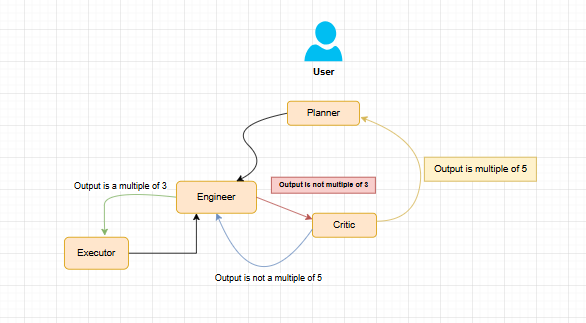

In [2]:
from autogen import GroupChat, AssistantAgent, UserProxyAgent, GroupChatManager
import os 
from dotenv import load_dotenv

In [3]:
## setup the environment
env_path= r"D:\common_credentials\.env"
load_dotenv(dotenv_path=env_path)
GROQ_API_KEY = os.getenv('GROQ_API_KEY')

In [67]:
config_list =[{'model': 'llama-3.3-70b-versatile',
               'api_key': GROQ_API_KEY,
               "api_type": "groq"}]

 ## LLM Config
llm_config = {"config_list": config_list}


# https://microsoft.github.io/autogen/0.2/docs/topics/llm_configuration
deepseek_config = {
    "cache_seed" : None,  #to get reproducible results always
    "temperaturre": 0,
    "config_list": config_list,
    "timeout": 120
}

In [74]:
# describe the task
task = """Add 1 to the number output by the previous role. If the previous number is 13, output "TERMINATE"."""

In [75]:
# agents configuration
engineer = AssistantAgent(
    name="Engineer",
    llm_config=deepseek_config,
    system_message=task,
    description="""I am **ONLY** allowed to speak **immediately** after `Planner`, `Critic` and `Executor`.
If the last number mentioned by `Critic` is not a multiple of 5, the next speaker must be `Engineer`.
"""
)

planner = AssistantAgent(
    name="Planner",
    system_message=task,
    llm_config=deepseek_config,
    description="""I am **ONLY** allowed to speak **immediately** after `User` or `Critic`.
If the last number mentioned by `Critic` is a multiple of 5, the next speaker must be `Planner`.
"""
)

executor = AssistantAgent(
    name="Executor",
    system_message=task,
    is_termination_msg=lambda x: x.get("content", "") and x.get("content", "").rstrip().endswith("FINISH"),
    llm_config=deepseek_config,
    description="""I am **ONLY** allowed to speak **immediately** after `Engineer`.
If the last number mentioned by `Engineer` is a multiple of 3, the next speaker can only be `Executor`.
"""
)


critic = AssistantAgent(
    name="Critic",
    system_message=task,
    llm_config=deepseek_config,
    description="""I am **ONLY** allowed to speak **immediately** after `Engineer`.
If the last number mentioned by `Engineer` is not a multiple of 3, the next speaker can only be `Critic`.
"""
)

user_proxy = UserProxyAgent(
    name="User",
    system_message=task,
    code_execution_config={ "use_docker":False},
    human_input_mode="NEVER",
    llm_config=False,
    
    description="""Never select me as a speaker."""
)



# Define & Visualize the Graph

In [76]:
# graph_dict= {}
# graph_dict[user_proxy] = [planner]
# graph_dict[planner] = [engineer]
# graph_dict[engineer] = [critic, executor]
# graph_dict[critic] = [engineer, planner]
# graph_dict[executor]=[engineer]


graph_dict= {
    user_proxy  : [planner],
    planner : [engineer],
    engineer    : [critic, executor],
    critic  :[engineer, planner],
    executor    : [engineer]
}

graph_dict


{<autogen.agentchat.user_proxy_agent.UserProxyAgent at 0x21875546410>: [<autogen.agentchat.assistant_agent.AssistantAgent at 0x2187546e150>],
 <autogen.agentchat.assistant_agent.AssistantAgent at 0x2187546e150>: [<autogen.agentchat.assistant_agent.AssistantAgent at 0x2187546c710>],
 <autogen.agentchat.assistant_agent.AssistantAgent at 0x2187546c710>: [<autogen.agentchat.assistant_agent.AssistantAgent at 0x2187546f9d0>,
 <autogen.agentchat.assistant_agent.AssistantAgent at 0x2187546f9d0>: [<autogen.agentchat.assistant_agent.AssistantAgent at 0x2187546c710>,
 <autogen.agentchat.assistant_agent.AssistantAgent at 0x21875546910>: [<autogen.agentchat.assistant_agent.AssistantAgent at 0x2187546c710>]}

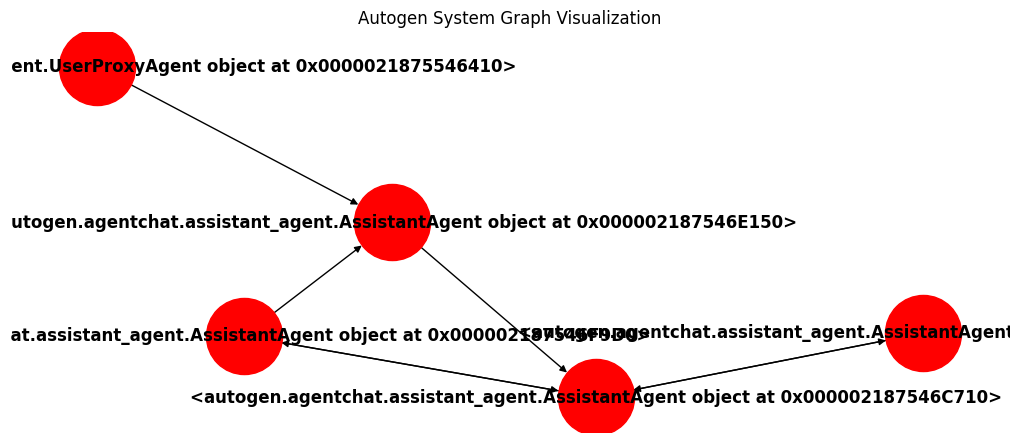

In [79]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph (DiGraph)
G = nx.DiGraph()

# Add edges from the graph dictionary
for node, neighbors in graph_dict.items():
    for neighbor in neighbors:
        G.add_edge(node, neighbor)

# Draw the graph using NetworkX and Matplotlib
plt.figure(figsize=(10,4))  # Size of the graph visualization
pos = nx.spring_layout(G)    # Positioning of nodes (spring layout works well for most cases)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='red', font_size=12, font_weight='bold', arrows=True)
plt.title("Autogen System Graph Visualization")
plt.show()


In [80]:
#Define groupchat & Groupchat manager

group_chat = GroupChat(
    agents=[user_proxy, planner, engineer, critic, executor],
    messages= [],
    max_round=25,
    allowed_or_disallowed_speaker_transitions=graph_dict, 
    allow_repeat_speaker=None, 
    speaker_transitions_type="allowed"
)


# create the manager
manager = GroupChatManager(
    groupchat=group_chat,
    llm_config=deepseek_config,
    is_termination_msg=lambda x: x.get("content", "") and x.get("content", "").rstrip().endswith("TERMINATE"),
    code_execution_config=False,
)

In [81]:
# initiate the task
user_proxy.initiate_chat(
    manager,
    message="1",
    clear_history=True
)

User (to chat_manager):

1

--------------------------------------------------------------------------------

Next speaker: Planner

Planner (to chat_manager):

2

--------------------------------------------------------------------------------

Next speaker: Engineer

Engineer (to chat_manager):

3

--------------------------------------------------------------------------------

Next speaker: Executor

Executor (to chat_manager):

4

--------------------------------------------------------------------------------

Next speaker: Engineer

Engineer (to chat_manager):

5

--------------------------------------------------------------------------------

Next speaker: Critic

Critic (to chat_manager):

6

--------------------------------------------------------------------------------

Next speaker: Engineer

Engineer (to chat_manager):

7

--------------------------------------------------------------------------------

Next speaker: Critic

Critic (to chat_manager):

8

----------------

ChatResult(chat_id=None, chat_history=[{'content': '1', 'role': 'assistant', 'name': 'User'}, {'content': '2', 'name': 'Planner', 'role': 'user'}, {'content': '3', 'name': 'Engineer', 'role': 'user'}, {'content': '4', 'name': 'Executor', 'role': 'user'}, {'content': '5', 'name': 'Engineer', 'role': 'user'}, {'content': '6', 'name': 'Critic', 'role': 'user'}, {'content': '7', 'name': 'Engineer', 'role': 'user'}, {'content': '8', 'name': 'Critic', 'role': 'user'}, {'content': '9', 'name': 'Engineer', 'role': 'user'}, {'content': '10', 'name': 'Executor', 'role': 'user'}, {'content': '11', 'name': 'Engineer', 'role': 'user'}, {'content': '12', 'name': 'Critic', 'role': 'user'}, {'content': '13 \n\nTERMINATE', 'name': 'Engineer', 'role': 'user'}], summary='13 \n\n', cost={'usage_including_cached_inference': {'total_cost': 0}, 'usage_excluding_cached_inference': {'total_cost': 0}}, human_input=[])